In [83]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
import copy
from tqdm import tqdm
import nevergrad as ng
import lpips

In [84]:
print(torch.__version__)

1.10.0+cu102


In [86]:
import os
os.environ["cuda_visible_devices"]='1'

# Choose variants here:

In [87]:
trained_model = False
arch = 'ResNet18'

## System setup:

In [ ]:
import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('ImageNet', defs, 
                                                                      data_path='/mnt/sda2/data/ImageNet')

model = torchvision.models.resnet18(pretrained=trained_model)
model.to(**setup)
model.eval();

In [89]:
dm = torch.as_tensor([0.5, 0.5, 0.5], **setup)[:, None, None]
ds = torch.as_tensor([0.5, 0.5, 0.5], **setup)[:, None, None]
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

## BigGAN model

In [90]:
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal, convert_to_images)

In [ ]:
# Load pre-trained model tokenizer (vocabulary)
generator= BigGAN.from_pretrained('biggan-deep-256').to(setup['device'])

# Reconstruct

### Build the input (ground-truth) gradient

[('Bernese mountain dog',)]
tensor([239], device='cuda:0')


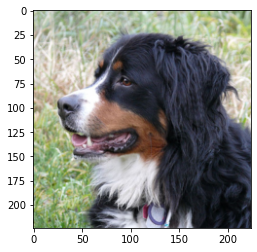

In [158]:
idx = 11967
# np.random.randint(len(validloader.dataset))

img, label = validloader.dataset[idx]
labels = torch.as_tensor((label,), device=setup['device'])
ground_truth = img.to(**setup).unsqueeze(0)
plot(ground_truth);
print([trainloader.dataset.classes[l] for l in labels]);
print(labels)

In [153]:
ground_truth_denormalized = torch.clamp(ground_truth * ds + dm, 0, 1)
# torchvision.utils.save_image(ground_truth_denormalized, f'{idx}_{arch}_ImageNet_input.png')

In [154]:
model.zero_grad()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
input_gradient = torch.autograd.grad(target_loss, model.parameters())
input_gradient = [grad.detach() for grad in input_gradient]
full_norm = torch.stack([g.norm() for g in input_gradient]).mean()
print(f'Full gradient norm is {full_norm:e}.')

Full gradient norm is 2.159137e+00.


## Reconstruction

In [155]:
import nevergrad as ng
from reconstructor import NGReconstructor

## CMA

In [156]:
ng_rec = NGReconstructor(fl_model=model, generator=generator, loss_fn=loss_fn,
                                     num_classes=1000, search_dim=(128,), strategy='CMA', budget=500, use_tanh=True, defense_setting=None)
z_res, x_res, img_res, loss_res = ng_rec.reconstruct(input_gradient)

Inferred label: tensor([239], device='cuda:0')


Loss 0.389028: 100%|██████████| 500/500 [17:51<00:00,  2.14s/it]


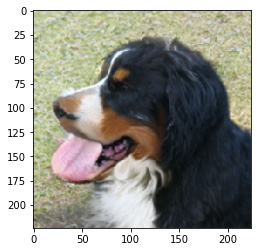

In [157]:
plot(x_res)

In [159]:
original_img = ground_truth.mul_(ds).add_(dm).clamp_(0, 1).mul_(255).permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
res_img = x_res.mul_(ds).add_(dm).clamp_(0, 1).mul_(255).permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
plt.imsave(os.path.join('out/', 'original.png'), original_img)
plt.imsave(os.path.join('out/', 'GAN_out.png'), res_img)